In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

# Load data

In [2]:
week1_anoms = xr.open_dataset('/glade/work/jhayron/Weather_Regimes/weekly_anomalies/week1_z500_anoms_v2.nc')

week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v2.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v2.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v2.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

week1_anoms = week1_anoms.sel(time=df_wr_2.index)
# week1_anoms = week1_anoms.sel(time=df_wr.index)
week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)

In [3]:
# region for clustering
lat0=10; lat1=70; lon0=210; lon1=320

In [4]:
week1_anoms = week1_anoms.where((week1_anoms.lon<=lon0)|(week1_anoms.lon>=lon1),drop=True)

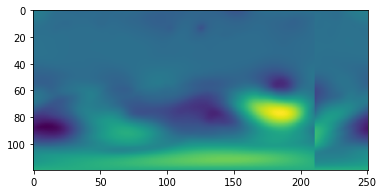

In [5]:
plt.imshow(week1_anoms.z500_anomalies.values[0])

In [6]:
week1_anoms = week1_anoms.roll(lon=40,roll_coords=True)

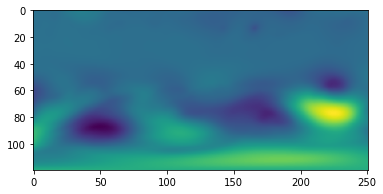

In [7]:
plt.imshow(week1_anoms.z500_anomalies.values[0])

## Quick check anomalies

In [8]:
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1_v2  = xr.open_dataset(f'{path_files}era5_z500_anoms_mean_week1.nc')

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


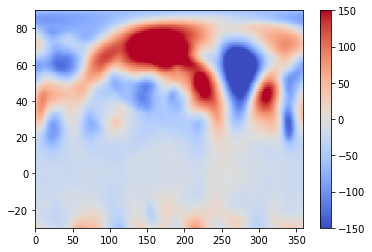

In [9]:
plt.pcolormesh(anoms_week_1_v2.lon,anoms_week_1_v2.lat,
               anoms_week_1_v2.isel(time= 0).anom,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


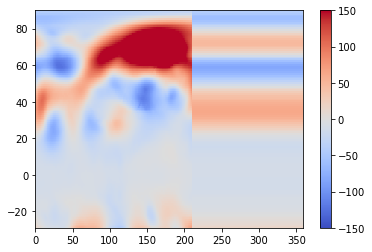

In [10]:
plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,
               week1_anoms.sel(time = datetime(1999,1,4)).z500_anomalies/9.82,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

## Quick check WR

In [11]:
serie_wr_week = np.load(f'{path_files}Serie_WR_Week{1}.npy')

In [12]:
df_old = pd.DataFrame(serie_wr_week,index = pd.to_datetime(anoms_week_1_v2.date_range.values))

In [13]:
df_old2 = copy.deepcopy(df_old)

In [14]:
df_old2[df_old==0] = 1
df_old2[df_old==1] = 0
df_old2[df_old==2] = 3
df_old2[df_old==3] = 2


In [15]:
df_comparison = pd.concat([df_old2,df_wr.week1],axis=1).dropna()

# Build model

In [8]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

## Tests

In [9]:
# week_output_wr = df_wr.week2.values.astype(int)
# # week_output_wr = df_wr_2.week2.values.astype(int)

# # Make Y categorical
# serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

# # # Scale by standard deviation
# # standard_deviation = week1_anoms.z500_anomalies.std(dim='time')
# # scaled_x = week1_anoms.z500_anomalies / standard_deviation

# Min = week1_anoms.z500_anomalies.min(dim='time')
# Max = week1_anoms.z500_anomalies.max(dim='time')

# scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

# indices = np.arange(len(serie_wr_categorical))
# #Reshape X
# scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

# indices_test = np.where(df_wr.week2.index.year>2010)[0]
# indices_train_val = np.where(df_wr.week2.index.year<=2010)[0]

# X_train, X_val, y_train, y_val, indices_train, indices_val \
#     = train_test_split(scaled_x[indices_train_val], serie_wr_categorical[indices_train_val], indices_train_val, test_size=0.15, random_state=42)

# X_test = scaled_x[indices_test]
# y_test = serie_wr_categorical[indices_test]

In [10]:
# week_output_wr = df_wr.week2.values.astype(int)
# # week_output_wr = df_wr_2.week2.values.astype(int)

# # Make Y categorical
# serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

# # # Scale by standard deviation
# # standard_deviation = week1_anoms.z500_anomalies.std(dim='time')
# # scaled_x = week1_anoms.z500_anomalies / standard_deviation

# Min = week1_anoms.z500_anomalies.min(dim='time')
# Max = week1_anoms.z500_anomalies.max(dim='time')

# scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

# indices = np.arange(len(serie_wr_categorical))
# #Reshape X
# scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

# indices_train = np.where(df_wr.week2.index.year<=2004)[0]
# indices_val = np.where((df_wr.week2.index.year>2004)&(df_wr.week2.index.year<=2010))[0]
# indices_test = np.where(df_wr.week2.index.year>2010)[0]

# X_test = scaled_x[indices_test]
# y_test = serie_wr_categorical[indices_test]

# X_train = scaled_x[indices_train]
# y_train = serie_wr_categorical[indices_train]

# X_val = scaled_x[indices_val]
# y_val = serie_wr_categorical[indices_val]

In [14]:
# week_output_wr = df_wr.week2.values.astype(int)
week_output_wr = df_wr_2.week2.values.astype(int)

# Make Y categorical
serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

# # Scale by standard deviation
# standard_deviation = week1_anoms.z500_anomalies.std(dim='time')
# scaled_x = week1_anoms.z500_anomalies / standard_deviation

Min = week1_anoms.z500_anomalies.min(dim='time')
Max = week1_anoms.z500_anomalies.max(dim='time')

scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

indices = np.arange(len(serie_wr_categorical))
#Reshape X
scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

X_test = scaled_x[indices_test]
y_test = serie_wr_categorical[indices_test]

X_train = scaled_x[indices_train]
y_train = serie_wr_categorical[indices_train]

X_val = scaled_x[indices_val]
y_val = serie_wr_categorical[indices_val]

In [15]:
wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
serie_wr_persistence_categorical = to_categorical(wr_persistence)

In [16]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model

keras.backend.clear_session()

# from tensorflow import set_random_seed
# set_random_seed(2)
model = create_model()

# visualkeras.layered_view(model).show() # display using your system viewer
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
# visualkeras.layered_view(model, scale_xy=1, legend=True,to_file=f'{path_figures}CNN_v1.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

batch_size = 128
epochs = 200
earlystop = EarlyStopping(monitor='val_loss', patience=5)
filepath = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights/checkpoint_w2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                             mode='auto',save_weights_only=False)
model.fit(X_train, y_train, batch_size=batch_size,\
    epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])


Epoch 1/200
18/18 [==============================] - 5s 290ms/step - loss: 1.3750 - accuracy: 0.3237 - val_loss: 1.3657 - val_accuracy: 0.3291
Epoch 2/200
11/18 [=================>............] - ETA: 1s - loss: 1.3585 - accuracy: 0.3303

KeyboardInterrupt: 

In [12]:
model.load_weights(filepath)

In [13]:
model.evaluate(x=X_test,y=y_test)

18/18 [==============================] - 0s 23ms/step - loss: 1.2077 - accuracy: 0.4403


[1.207700490951538, 0.44028520584106445]

In [14]:
log_loss(y_test,serie_wr_persistence_categorical)

19.45499704398361

In [15]:
log_loss(y_test,model.predict(X_test))

1.2077005540889003

In [16]:
accuracy_score(y_test,serie_wr_persistence_categorical)

0.43672014260249553

In [17]:
y_predicted_test = model.predict(X_test)

In [18]:
y_predicted_test_discrete = np.zeros_like(y_predicted_test)
for i in range(len(y_predicted_test_discrete)):
    y_predicted_test_discrete[i,np.argmax(y_predicted_test,axis=1)[i]] = 1

In [19]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 15ms/step - loss: 1.2077 - accuracy: 0.4403


[1.207700490951538, 0.44028520584106445]

In [20]:
accuracy_score(y_test,y_predicted_test_discrete)

0.44028520499108736

# Train definitive

In [15]:
def create_model(input_shape,activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=input_shape,padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model


# Using the mean geopotential of the week to compute WR

In [12]:
loss_weeks_model = []
loss_weeks_persistence = []
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week2','week3','week4','week5','week6']:
    print(week)
    #### ORGANIZE DATA ####
    
    week_output_wr = df_wr_2[week].values.astype(int)
    # Make Y categorical
    serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

    # # Scale by min-max
    Min = week1_anoms.z500_anomalies.min(dim='time')
    Max = week1_anoms.z500_anomalies.max(dim='time')
    scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

    indices = np.arange(len(serie_wr_categorical))
    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

    indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
    indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
    indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

    X_test = scaled_x[indices_test]
    y_test = serie_wr_categorical[indices_test]

    X_train = scaled_x[indices_train]
    y_train = serie_wr_categorical[indices_train]

    X_val = scaled_x[indices_val]
    y_val = serie_wr_categorical[indices_val]
    
    wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
    serie_wr_persistence_categorical = to_categorical(wr_persistence)
    
    #### TRAIN ####
    
    keras.backend.clear_session()
    model = create_model()
    batch_size = 128
    epochs = 200
    
    earlystop = EarlyStopping(monitor='val_loss', patience=5)
    filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_{week}_v2.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                 mode='auto',save_weights_only=False)
    model.fit(X_train, y_train, batch_size=batch_size,\
        epochs=epochs,verbose=0,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])
    
    # earlystop = EarlyStopping(monitor='loss', patience=5)
    # filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_{week}_v2.h5'
    # checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, 
    #                              mode='auto',save_weights_only=False)
    # model.fit(X_train, y_train, batch_size=batch_size,\
    #     epochs=epochs,verbose=1, callbacks=[checkpoint,earlystop])
    
    #### EVAL ####
    
    model.load_weights(filepath)
    model.save(filepath)
    metrics_model = model.evaluate(x=X_test,y=y_test)
    acc_temp = metrics_model[1]
    loss_temp = metrics_model[0]
    acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
    loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
    print('loss/acc model')
    print(metrics_model)
    print('loss/acc persistence')
    print([loss_persistence,acc_persistence])
    
    loss_weeks_model.append(loss_temp)
    loss_weeks_persistence.append(loss_persistence)
    acc_weeks_model.append(acc_temp)
    acc_weeks_persistence.append(acc_persistence)


week2
18/18 [==============================] - 0s 14ms/step - loss: 1.2257 - accuracy: 0.4314
loss/acc model
[1.2256555557250977, 0.4313725531101227]
loss/acc persistence
[19.45499704398361, 0.43672014260249553]
week3
18/18 [==============================] - 0s 14ms/step - loss: 1.3419 - accuracy: 0.3369
loss/acc model
[1.3419171571731567, 0.3368983864784241]
loss/acc persistence
[25.365375892788755, 0.26559714795008915]
week4
18/18 [==============================] - 0s 15ms/step - loss: 1.3492 - accuracy: 0.3316
loss/acc model
[1.3491865396499634, 0.33155080676078796]
loss/acc persistence
[25.119110107421875, 0.2727272727272727]
week5
18/18 [==============================] - 0s 14ms/step - loss: 1.3536 - accuracy: 0.3155
loss/acc model
[1.35358726978302, 0.31550800800323486]
loss/acc persistence
[24.38031275132123, 0.29411764705882354]
week6
18/18 [==============================] - 0s 16ms/step - loss: 1.3694 - accuracy: 0.3422
loss/acc model
[1.3693881034851074, 0.34224599599838257]


# Using the most frequent WR

In [12]:
# loss_weeks_model = []
# loss_weeks_persistence = []
# acc_weeks_model = []
# acc_weeks_persistence = []

# for week in ['week2','week3','week4','week5','week6']:
#     print(week)
#     #### ORGANIZE DATA ####
    
#     week_output_wr = df_wr[week].values.astype(int)
#     # Make Y categorical
#     serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

#     # # Scale by min-max
#     Min = week1_anoms.z500_anomalies.min(dim='time')
#     Max = week1_anoms.z500_anomalies.max(dim='time')
#     scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

#     indices = np.arange(len(serie_wr_categorical))
#     #Reshape X
#     scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

#     indices_train = np.where(df_wr.week2.index.year<=2001)[0]
#     indices_val = np.where((df_wr.week2.index.year>2001)&(df_wr.week2.index.year<=2010))[0]
#     indices_test = np.where(df_wr.week2.index.year>2010)[0]

#     X_test = scaled_x[indices_test]
#     y_test = serie_wr_categorical[indices_test]

#     X_train = scaled_x[indices_train]
#     y_train = serie_wr_categorical[indices_train]

#     X_val = scaled_x[indices_val]
#     y_val = serie_wr_categorical[indices_val]
    
#     wr_persistence = df_wr.week1.values.astype(int)[indices_test]
#     serie_wr_persistence_categorical = to_categorical(wr_persistence)
    
#     #### TRAIN ####
    
#     keras.backend.clear_session()
#     model = create_model()
#     batch_size = 128
#     epochs = 200
    
#     earlystop = EarlyStopping(monitor='val_loss', patience=5)
#     filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_{week}_v2.h5'
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
#                                  mode='auto',save_weights_only=False)
#     model.fit(X_train, y_train, batch_size=batch_size,\
#         epochs=epochs,verbose=0,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])
    
#     #### EVAL ####
    
#     model.load_weights(filepath)
#     model.save(filepath)
#     metrics_model = model.evaluate(x=X_test,y=y_test)
#     acc_temp = metrics_model[1]
#     loss_temp = metrics_model[0]
#     acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
#     loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
#     print('loss/acc model')
#     print(metrics_model)
#     print('loss/acc persistence')
#     print([loss_persistence,acc_persistence])
    
#     loss_weeks_model.append(loss_temp)
#     loss_weeks_persistence.append(loss_persistence)
#     acc_weeks_model.append(acc_temp)
#     acc_weeks_persistence.append(acc_persistence)


week2
14/14 [==============================] - 0s 31ms/step - loss: 1.2545 - accuracy: 0.4263
loss/acc model
[1.2545249462127686, 0.4263038635253906]
loss/acc persistence
[19.188209109836155, 0.4444444444444444]
week3
14/14 [==============================] - 0s 14ms/step - loss: 1.3554 - accuracy: 0.3288
loss/acc model
[1.3554285764694214, 0.32879817485809326]
loss/acc persistence
[24.592235348932867, 0.28798185941043086]
week4
14/14 [==============================] - 0s 14ms/step - loss: 1.3629 - accuracy: 0.3107
loss/acc model
[1.3629425764083862, 0.3106575906276703]
loss/acc persistence
[24.905512232358763, 0.2789115646258503]
week5
14/14 [==============================] - 0s 14ms/step - loss: 1.3506 - accuracy: 0.3265
loss/acc model
[1.3505852222442627, 0.3265306055545807]
loss/acc persistence
[23.809043140368125, 0.31065759637188206]
week6
14/14 [==============================] - 0s 15ms/step - loss: 1.3675 - accuracy: 0.3333
loss/acc model
[1.3674802780151367, 0.3333333432674408]

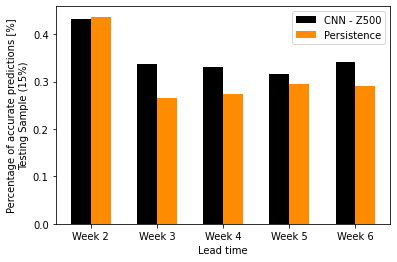

In [13]:
plt.bar(np.arange(5),acc_weeks_model,width=-0.3,align='edge',label='CNN - Z500',color='k')
plt.bar(np.arange(5),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (15%)')
plt.xticks(np.arange(5),['Week 2','Week 3','Week 4','Week 5','Week 6'])
plt.xlabel('Lead time')
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Skill_CNNv2vsPersistence.png',bbox_inches='tight')


In [15]:
len(serie_wr_categorical)

3269

# Plot structure of model

In [21]:
model = create_model((week1_anoms.z500_anomalies.shape[1],week1_anoms.z500_anomalies.shape[2],1))
filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_week2_v2.h5'
model.load_weights(filepath)

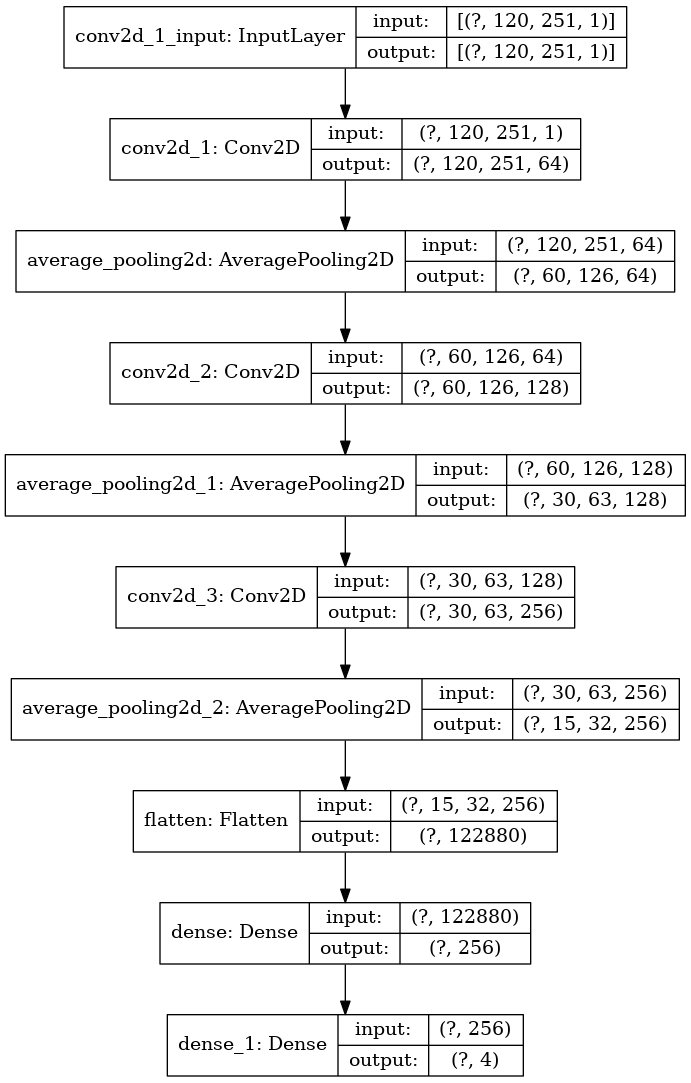

In [24]:
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
keras.utils.plot_model(model, show_shapes=True,to_file= f'{path_figures}CNN_Architecture.png')